### 1. Importing Required Modules & Libraries

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import parallel_coordinates
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import sklearn.cluster as cluster
import scipy.optimize as opt
import matplotlib.gridspec as gridspec 

### 2. Defining Functions

In [27]:
#Functions used for this projects mentioned below

def World_Bank_Reader(wb_file_name):
    """This is the docstring of the function World_Bank_Reader to read the data from the world bank csv
    file downloaded from the world bank site """
    
    #Reading data from the world bank csv file downloaded from the world bank website
    climate_change_df = pd.read_csv(wb_file_name, skiprows=4) 
    
    climate_change_df.drop(climate_change_df.columns[[-1]], axis=1, inplace=True)
    
    #Deriving data with Years as columns
    climate_year_df = climate_change_df[:]  
    
    #Deriving dataframe with country name as columns
    climate_country_df = climate_change_df.groupby(['Country Name']).aggregate('first').transpose()
    
    return climate_country_df, climate_year_df

### PART 1- Functions Normalization & Clustering

def norm_fun(data):
    """ Returns array normalised to [0,1]. Array can be a numpy array 
    or a column of a dataframe"""

    minimum_val = np.min(data)
    maximum_val = np.max(data)
    
    norm_data = (data-minimum_val)/(maximum_val-minimum_val)
    
    return norm_data


def normalize_df(norm_data):
    
    """ Returns all columns of the dataframe normalised to [0,1] with the 
    exception the first (containing the names)
    Calls function norm to do the normalisation of one column, but
    doing all in one function is also fine"""
    
    # iterate over all columns
    for cc_column in norm_data.columns[1:]:     # excluding the first column
        norm_data[cc_column] = norm_fun(norm_data[cc_column])
        
    return norm_data


def square_plot(data, xaxis, yaxis):
    
    """Produces a square plot of two columns of dataframe df using small circle 
    symbols."""
    
    plt.plot(data[xaxis], data[yaxis], "o", markersize=6)
    
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    

def heat_map(data):
    
    """Heat Map function for plotting the correlation data using the Correlation data recieved from the .Corr() function"""
    
    # Setting up the style
    plt.style.use('dark_background')
    
    # Using heatmap function from the SNS library for ploting heat map
    sns.heatmap(data, annot=True, cmap="YlGnBu")
    
    plt.show()
    

    
def K_mean (data, xaxis, yaxis, n, title):
    
    #kmeans set up the clusterer, n expected clusters
    kmeans = cluster.KMeans(n_clusters=n)

    #extract columns for fitting
    data_fit = data[[xaxis, yaxis]].copy()
    kmeans.fit(data_fit)     

    # extract labels and cluster centres
    cluster_labels = kmeans.labels_
    cluster_center = kmeans.cluster_centers_

    # plot using the labels to select colour
    col = ["blue", "red", "green", "magenta", "yellow", "orange"]
    
    # loop over the different labels
    for l in range(n):     
        plt.plot(data_fit[xaxis][cluster_labels==l], data_fit[yaxis][cluster_labels==l],
                 "o", markersize=8, color=col[l])
    
    # show cluster centres
    for iter_cent in range(n):
        xcluster, ycluster = cluster_center[iter_cent,:]
        plt.plot(xcluster, ycluster, "dk", markersize=12, color='white')
    
    plt.title (title)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    
  

    #PART 2-FITTING Functions defined below

def exp_growth(time, scale_val, growth_val):
    """ Calculating exponential_function 'xf' with scale value and growth value as free_parameters"""
    
    xf = scale_val*np.exp(growth_val*(time-1960)) 
    
    return xf
        

def logistics(time, scale_val, growth_val, time0):
    """ Calculating logistics_function 'lm' with scale_value & growth_value
    and time'0' as the triggering point as free parameter_values"""
    
    lf = scale_val/(1.0+np.exp(-growth_val*(time-time0)))
    
    return lf


def err_ranges(data, modl, parameter, sigma_val):
    
    """Calculates the upper_limits and lower_limits for the corresponding function.
    The parameter and sigma for single value. Function values are calculated for 
    all combination of +&- sigmas and the minimum and maximum is identified."""

    import itertools as iter
    
    # initiate arrays for lower/upper_limits
    lower_lim = modl(data, *parameter)
    upper_lim = lower_lim
    
    # holding upper and lower limits for parameters into a list
    uplow_lim = []
    
    #iteration
    for q,t in zip(parameter, sigma_val):
        pmin_val = q-t
        pmax_val = q+t
        uplow_lim.append((pmin_val, pmax_val))
        
    pmix_val = list(iter.product(*uplow_lim))
    
    for q in pmix_val:
        y_modl = modl(data, *q)
        lower_lim = np.minimum(lower_lim, y_modl)
        upper_lim = np.maximum(upper_lim, y_modl)
        
    return lower_lim, upper_lim


def fit_plot(data, xaxis, yaxis, fit_param, xlbl, ylbl, title, cl1, cl2):
    
    """ Simple Fitting plot by taking data & axis values with lables and color parameters"""
    
    plt.figure()
    plt.plot(data[xaxis], data[yaxis], label="Data", color=cl1)
    plt.plot(data[xaxis], data[fit_param], label="Fit", color=cl2)

    plt.legend()
    plt.title(title)
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

def fit_err_plot(data, low, up, xaxis, yaxis, fit_param, xlbl, ylbl, title, cl1, cl2, cl3):
    
    """ Plotting the Fitting plot with Error / confidence values obtained w.r.t the fitting parameters.
        This function takes, data with lower and upper limits with x & y axis parameters"""
    
    plt.figure()
    plt.title(title)
    plt.plot(data[xaxis], data[yaxis], label="Data", color=cl1)
    plt.plot(data[xaxis], data[fit_param], label="Fit", color=cl2)

    plt.fill_between(data[xaxis], low, up, alpha=0.9, color=cl3)
    plt.legend()
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()
    
def best_fit_plot(data, env_data, forcast, low, up, xaxis, yaxis, xlbl, ylbl, title, col1, col2, col3):
    """ Plotting the Best Fitting plot with Error / confidence values obtained w.r.t the fitting parameters.
        This function takes, data with lower & upper limits with x & y axis parameters. Also passing confidence
        value as the envelop for the fitted data"""
    
    plt.figure()
    plt.title(title)
    plt.plot(data[xaxis], data[yaxis], label=ylbl, color=col1)
    plt.plot(env_data, forcast, label="Forecast", color=col2)

    plt.fill_between(env_data, low, up, alpha=0.9, color=col3)
    plt.legend()
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

### 3. Defining Global Variables and Parameters

In [28]:
#Defining Global Variables & List used for the use of data manipulation

Total_urban_CO2 emissions= "SP.POP.TOTL"
CO2_emissions = "EN.ATM.CO2E.KT"
Renewable_energy_consumption  = "EG.FEC.RNEW.ZS"
Forest_area ='AG.LND.FRST.K2'
Total_greenhouse_gas_emissions='EN.ATM.GHGT.ZG'

urban_CO2 emissions="SP.URB.TOTL"
CO2 emissions = "EG.ELC.RNWX.KH"
Foreign_invest = "EG.USE.PCAP.KG.OE"


#Indicator_replace list used to replace the Indicator code with an understandig words
Indicator_replace = {"SP.POP.TOTL":"Total_urban_CO2 emissions","EN.ATM.CO2E.KT":"CO2 emissions","EG.FEC.RNEW.ZS":"Renewable_energy",'AG.LND.FRST.K2':'Forest_area','EN.ATM.GHGT.ZG':'Total_greenhouse_gas_emissions',
                  "SP.URB.TOTL":"urban_CO2 emissions","EG.ELC.RNWX.KH":"CO2 emissions","EG.USE.PCAP.KG.OE":"Foreign_invest"}

#Indicator_map used for maping the data-frame with corresponding indicators used by World bank data
Indicator_map = ["SP.POP.TOTL","EN.ATM.CO2E.KT","EG.FEC.RNEW.ZS","SP.URB.TOTL","EG.ELC.RNWX.KH","EG.USE.PCAP.KG.OE",'EN.ATM.GHGT.ZG','AG.LND.FRST.K2']

### 4. Reading Data Frames using Funtion From the World Bank Data File

In [29]:
#Assigning World Bank Data file name to a variable
wb_file_name = '/kaggle/input/worldbankdat/World_Bank_Data_File.csv'

In [30]:
#Using World Bank Reader function defined in the function section to generate 2x data frame as per the assignment requirement
country_df, year_df = World_Bank_Reader(wb_file_name)

###### 4.1 Returning Dataframe with Transposed format ( Countries as columns )

In [31]:
country_df.head()

Country Name,Afghanistan,Africa Eastern and Southern,Africa Western and Central,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Arab World,...,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe
Country Code,AFG,AFE,AFW,ALB,DZA,ASM,AND,AGO,ATG,ARB,...,UZB,VUT,VEN,VNM,VIR,PSE,WLD,YEM,ZMB,ZWE
Indicator Name,Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),...,Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population)
Indicator Code,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,...,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS
1960,8.401,14.704688,14.670329,30.705,30.51,66.211,58.45,10.435,39.656,31.234142,...,33.978,10.404,61.613,14.7,56.477,44.044,33.617972,9.1,18.145,12.608
1961,8.684,14.944459,15.053577,30.943,31.797,66.641,60.983,10.798,39.04,31.979927,...,34.238,10.583,62.875,15.031,57.864,44.734,34.11549,9.459,18.951,12.821


###### 4.2 Returning Dataframe with Original Format (Years as columns)

In [32]:
year_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.776,50.761000,50.746000,50.730000,50.715000,50.700000,...,42.940000,42.957000,42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000
1,Aruba,ABW,Urban population,SP.URB.TOTL,27525.000,28139.000000,28537.000000,28763.000000,28922.000000,29080.000000,...,43820.000000,44059.000000,44351.000000,44666.000000,44978.000000,45293.000000,45614.000000,45949.000000,46294.000000,46654.000000
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,NaN,2.206183,1.404498,0.788835,0.551271,0.544810,...,0.100461,0.543931,0.660561,0.707733,0.696090,0.697901,0.706219,0.731740,0.748028,0.774631
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.000,55434.000000,56234.000000,56699.000000,57029.000000,57357.000000,...,102050.000000,102565.000000,103165.000000,103776.000000,104339.000000,104865.000000,105361.000000,105846.000000,106310.000000,106766.000000
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,NaN,2.236462,1.432843,0.823502,0.580334,0.573498,...,0.377979,0.503385,0.583290,0.590508,0.541048,0.502860,0.471874,0.459266,0.437415,0.428017


### 5. Re-arranging Data frame for the Analysis

#### 5.1 Arranging Data Frame

In [33]:
# Filtering out the required indicators for the anlysis from the previously defined Indicator Map list
year_df_new = year_df[year_df['Indicator Code'].isin(Indicator_map)]

In [34]:
# Replacing Not Identifiable Indicator code in to a known Identifiers
year_df_new["Indicator Code"].replace(Indicator_replace, inplace=True)

year_df_new = year_df_new.copy(deep=True) #To avoid warning related to the 'caveat'

In [35]:
# Droping Country Name  & Indicator Name as it is already defined
year_df_new = year_df_new.drop(['Country Code', 'Indicator Name'], axis=1, inplace=False)

In [36]:
country_data = year_df_new.reset_index()

In [37]:
#Normalizing the index for the easy analysis
country_data.drop(['index'], axis=1, inplace=True)

In [38]:
stat_data = country_data.groupby(['Country Name', 'Indicator Code']).aggregate('mean')

In [39]:
df_env_f = stat_data.stack().unstack(level=1)

stat_data2 = df_env_f.groupby(['Country Name']).aggregate('mean')

In [40]:
stat_data_orig = stat_data2.reset_index()

#### 5.2 Handling Null Values

In [42]:
# Handling the null values
stat_data_orig['CO2 emissions'].fillna(stat_data_orig['CO2 emissions'].mean(), inplace=True)
stat_data_orig['CO2 emissions'].fillna(stat_data_orig['CO2 emissions'].mean(), inplace=True)
stat_data_orig['Foreign_invest'].fillna(stat_data_orig['Foreign_invest'].mean(), inplace=True)
stat_data_orig['Renewable_energy'].fillna(stat_data_orig['Renewable_energy'].mean(), inplace=True)
stat_data_orig['Total_urban_CO2 emissions'].fillna(stat_data_orig['Total_urban_CO2 emissions'].mean(), inplace=True)
stat_data_orig['urban_CO2 emissions'].fillna(stat_data_orig['urban_CO2 emissions'].mean(), inplace=True)
stat_data_orig['Total_greenhouse_gas_emissions'].fillna(stat_data_orig['Total_greenhouse_gas_emissions'].mean(), inplace=True)
stat_data_orig['Forest_area'].fillna(stat_data_orig['Forest_area'].mean(), inplace=True)

In [43]:
stat_data_orig.isnull().any()

Indicator Code
Country Name                      False
CO2 emissions                     False
Electricity                       False
Foreign_invest                    False
Forest_area                       False
Renewable_energy                  False
Total_greenhouse_gas_emissions    False
Total_urban_population            False
urban_population                  False
dtype: bool

### 6. Normalization

###### 6.1 Checking the Statistics Parmeters on the Original Data

In [44]:
print(stat_data_orig.describe())

Indicator Code  CO2 emissions   Electricity  Foreign_invest   Forest_area  \
count            2.650000e+02  2.650000e+02      265.000000  2.650000e+02   
mean             7.670962e+05  1.019185e+10     1895.796921  1.649439e+06   
std              2.393280e+06  2.625626e+10     2156.914839  4.973255e+06   
min              1.000000e+01  0.000000e+00       12.400284  0.000000e+00   
25%              1.730745e+03  3.557778e+07      583.991525  3.586919e+03   
50%              2.130038e+04  1.468311e+09     1417.530562  3.845968e+04   
75%              2.752195e+05  1.019185e+10     2094.327008  3.178232e+05   
max              2.171066e+07  2.350456e+11    18278.542119  4.050289e+07   

Indicator Code  Renewable_energy  Total_greenhouse_gas_emissions  \
count                 265.000000                      265.000000   
mean                   31.060149                       39.929938   
std                    29.144524                      112.885960   
min                     0.000000  

###### 6.2 Finding the Correlation between Indicators on Original Data

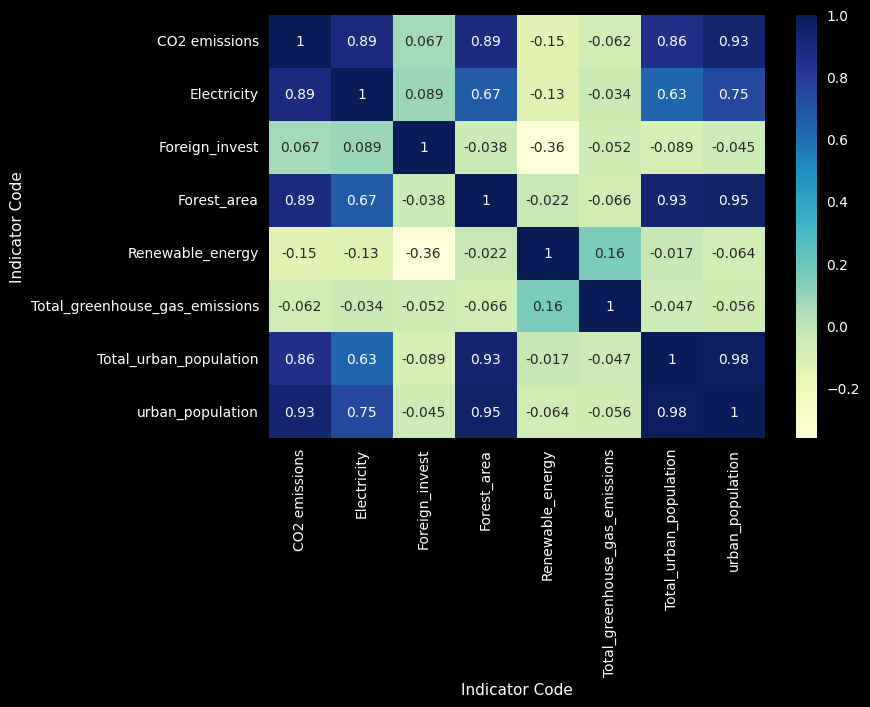

In [54]:
numeric_data = stat_data_orig.select_dtypes(include=[np.number])

# Calculate the correlation matrix
data_corr = numeric_data.corr()  

# Assuming heat_map is a function you've defined to plot the correlation matrix
heat_map(data_corr)


###### 6.3 Normalizing the Data & Displaying the Correlation

In [55]:
# Normalizing the data for the good fitting & displaying the statistical parameters of the data frame

stat_data_orig = normalize_df(stat_data_orig)

print(stat_data_orig.describe())

Indicator Code  CO2 emissions  Electricity  Foreign_invest  Forest_area  \
count              265.000000   265.000000      265.000000   265.000000   
mean                 0.035332     0.043361        0.103109     0.040724   
std                  0.110235     0.111707        0.118083     0.122788   
min                  0.000000     0.000000        0.000000     0.000000   
25%                  0.000079     0.000151        0.031292     0.000089   
50%                  0.000981     0.006247        0.076925     0.000950   
75%                  0.012676     0.043361        0.113977     0.007847   
max                  1.000000     1.000000        1.000000     1.000000   

Indicator Code  Renewable_energy  Total_greenhouse_gas_emissions  \
count                 265.000000                      265.000000   
mean                    0.321915                        0.063592   
std                     0.302061                        0.070600   
min                     0.000000                    

### 7. Pre-Processing - Plot a few combinations of attributes (using a function on GridSpec() )

We are looking into the possibility of different combinations of Indicators to make interesting clusters by using the Scatter Plot. From the below plots we understand that below parameters are good for making analyzable clusters 

#### 1. CO2 vs CO2 emissions 
#### 2. Forest Area vs CO2 emissions 
#### 3. CO2 vs Forest Area
#### 4. Renewable Energy vs CO2 emissions
#### 5. Energy Use vs CO2 emissions 
#### 6. Renewable Energy vs CO2

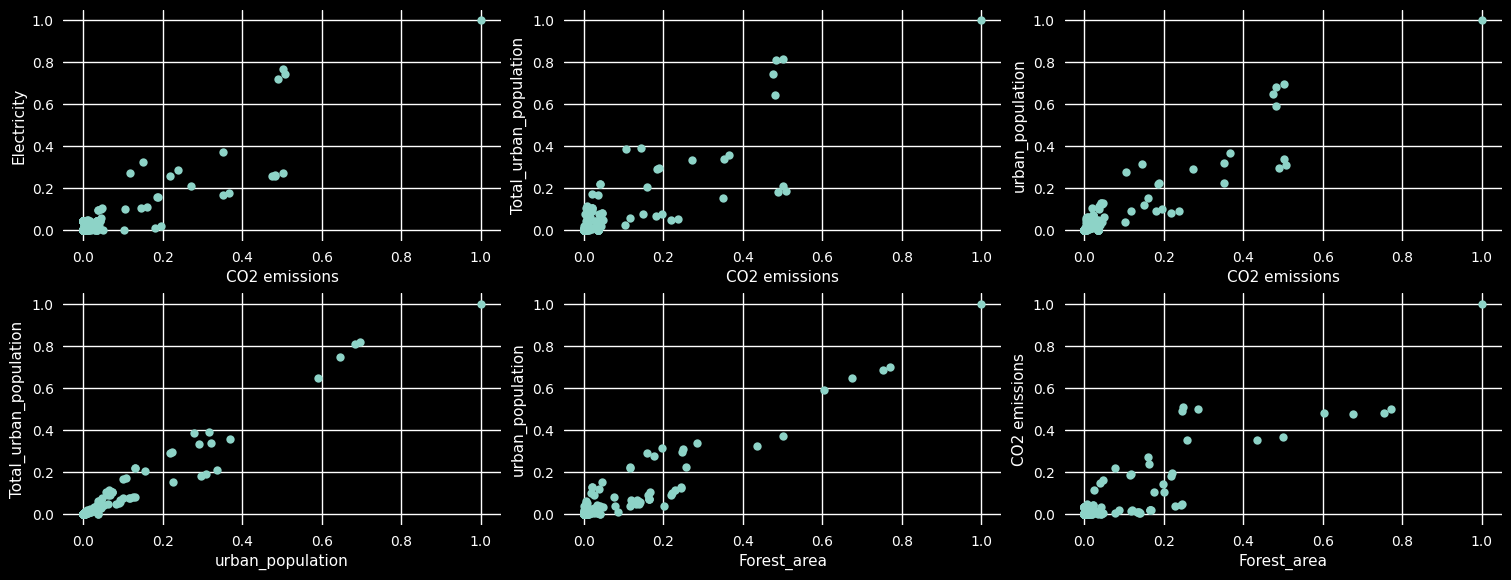

In [57]:
# Set up gridspec figure
fig = plt.figure(figsize=(15,8), constrained_layout=True)  # Setting the layout size to print it on the A4 Sheet

# Setting the Columns & Rows to the Grid Spec object
gs = fig.add_gridspec(nrows=3, ncols=3) 

ax1 = fig.add_subplot(gs[0,0])
#ax1.set_axis_off()

square_plot(stat_data_orig, "CO2 emissions", "CO2 emissions")

ax2 = fig.add_subplot(gs[0,1])
square_plot(stat_data_orig, "CO2 emissions", "Total_urban_CO2 emissions")

ax3 = fig.add_subplot(gs[0,2])
square_plot(stat_data_orig, "CO2 emissions", "urban_CO2 emissions")


ax4 = fig.add_subplot(gs[1,0])
square_plot(stat_data_orig, "urban_CO2 emissions", "Total_urban_CO2 emissions")


ax5 = fig.add_subplot(gs[1,1])
square_plot(stat_data_orig, "Forest_area", "urban_CO2 emissions")

ax6 = fig.add_subplot(gs[1,2])
square_plot(stat_data_orig, "Forest_area", "CO2 emissions")






### 8. Clustering Using K-Means Algorithm and Displaying Cluster Membership

 From the above plots, we understand that 6 different plots are providing closer clusering. Using pre-defined custom function of K-means to find the clusters on the selected indicators. Here we are choosing cluster number as 4 for the clustering with reference to the above pre-processing step

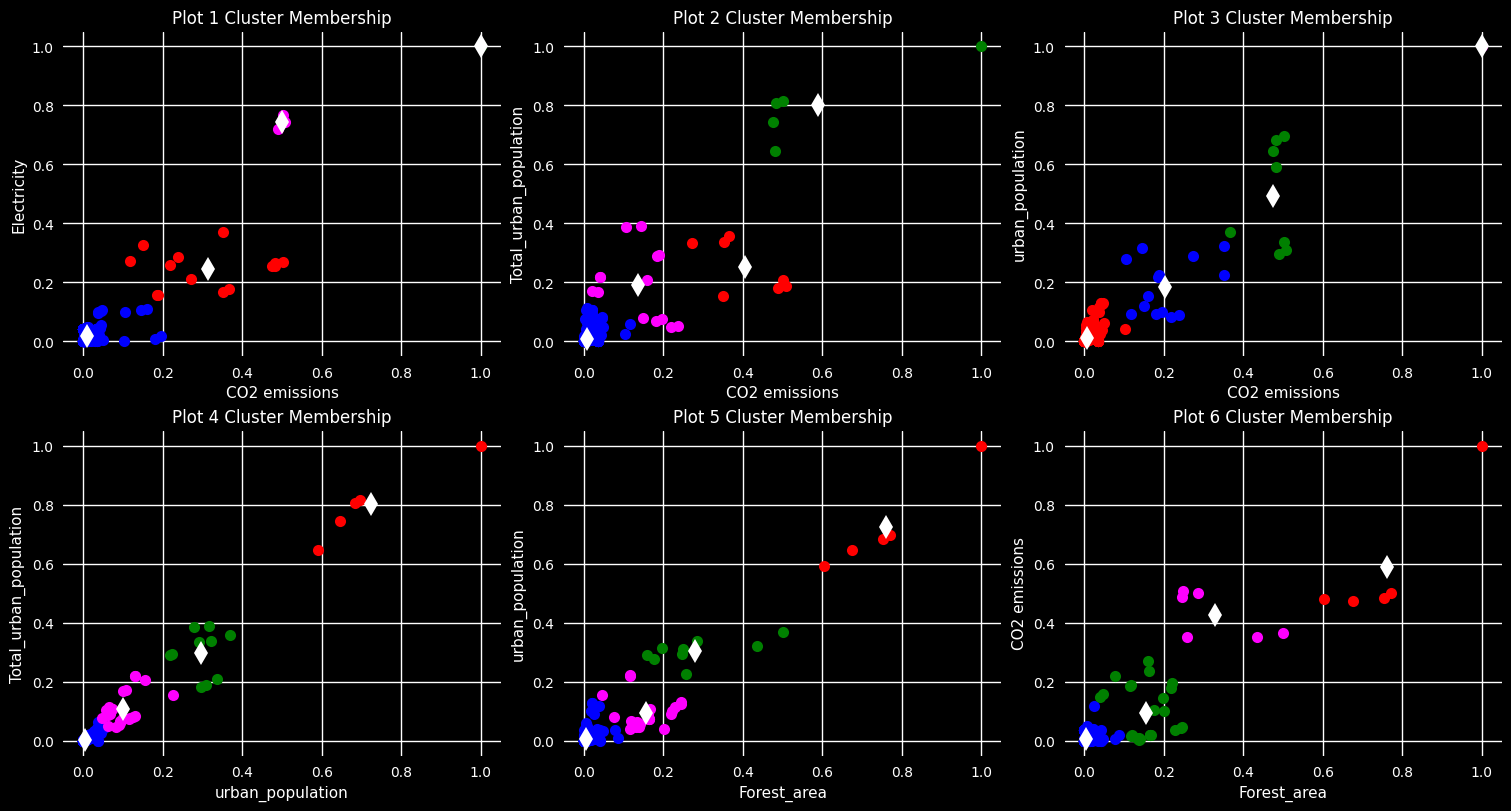

In [58]:
# Set up gridspec figure
fig = plt.figure(figsize=(15, 8), constrained_layout=True)  # Setting the layout size to print it on the A4 Sheet

# Setting the Columns & Rows to the Grid Spec object
gs = fig.add_gridspec(nrows=2, ncols=3) 
ax1 = fig.add_subplot(gs[0,0])
#ax1.set_axis_off()
K_mean (stat_data_orig,"CO2 emissions", "CO2 emissions", 4, "Plot 1 Cluster Membership")

ax2 = fig.add_subplot(gs[0,1])
K_mean (stat_data_orig,"CO2 emissions", "Total_urban_CO2 emissions", 4, "Plot 2 Cluster Membership")

ax3 = fig.add_subplot(gs[0,2])
K_mean (stat_data_orig,"CO2 emissions", "urban_CO2 emissions", 4, "Plot 3 Cluster Membership")


ax4 = fig.add_subplot(gs[1,0])
K_mean (stat_data_orig,"urban_CO2 emissions", "Total_urban_CO2 emissions", 4, "Plot 4 Cluster Membership")


ax5 = fig.add_subplot(gs[1,1])
K_mean (stat_data_orig,"Forest_area", "urban_CO2 emissions", 4, "Plot 5 Cluster Membership")


ax6 = fig.add_subplot(gs[1,2])
K_mean (stat_data_orig,"Forest_area", "CO2 emissions", 4, "Plot 6 Cluster Membership")

### 9. Analysis & Findings on Clustering Data

Compare some results and showing our findings


- 1. **Plot 1- CO2 vs CO2 emissions** - Majority of the countries are grouped in blue & pink clusters are having lesser Carbon Emissions over the   last 60 Years beacuse of the lesser CO2 emissions. Few of the countries with higher CO2 emissions emitting lesser Carbon also


- 2. **Plot 2- Forest Area vs CO2 emissions** - Most of the countries with an avergae CO2 emissions having lesser forest area because of the available land for living. Some countries with higher CO2 emissions like China showing higher land areas.



- 3. **Plot 3- CO2 vs Forest Area** - The countries clustered on the Red color poses lower CO2 because of the higher forest area.



- 4. **Plot 4- Renewable Energy Use vs CO2 emissions** - Countries with lesser CO2 emissions (Red Cluster) started to use more renewable energy than the others (eg:- Green Cluster).



- 5. **Plot 5- Energy Use vs CO2 emissions** - Most of the countries ( on Red Cluser's) using lesser energy because of the lesser CO2 emissions. But few countries like , Middle East Countries having lesser CO2 emissions consuming more energy. This is because of the easy availability & lesser cost of the Natural Gas/Petrolium Resources.



- 6. **Plot 6- Renewable Energy Use vs CO2** - The countries on the Red cluster showing lesser Carbon Emission, because of the use of higher renewable energy use. The countries on the Pink cluster showing opposite to the above said Red clusters. They are having highest Carbon Emission because of the lesser use of the Renewable Energy



# 10. Fitting & Prediction ( till the year 2050)

- Step-1 Here we are using the Time series data of two countries ( China & India ) against the CO2 emissions from the year between 1960 to 2020. Since both are showing highest CO2 emissions growth over the years.


- Step-2 For the fitting of the data we are using the curve_fit function and generating the model. 


- Step-3 We will use two modelling scheme here. Using exponential growth and logistic function. 


- Step-4 We will use Both models for the prediction


- Step-5 Using the Error_range function, we will find out the limits and confidence ranges of both the predictions


- Step-6 Finally we will plot the Best Fitted Model with predictions and confidence ranges.

In [106]:
df_env_f.isnull().any()

Indicator Code
CO2 emissions                     True
Electricity                       True
Foreign_invest                    True
Forest_area                       True
Renewable_energy                  True
Total_greenhouse_gas_emissions    True
Total_urban_population            True
urban_population                  True
dtype: bool

### 10.1 Generating the Time series data of India and China

In [107]:
df_env_f=df_env_f.dropna()

In [108]:
df_env_f.isnull().any()

Indicator Code
CO2 emissions                     False
Electricity                       False
Foreign_invest                    False
Forest_area                       False
Renewable_energy                  False
Total_greenhouse_gas_emissions    False
Total_urban_population            False
urban_population                  False
dtype: bool

In [109]:
# Extracting CO2 emissions data of India & China from the world bank data frame using pandas data frame slicing

pop_stat = df_env_f.loc[['India'], ['CO2 emissions']]

pop_stat_chn = df_env_f.loc[['China'], ['CO2 emissions']]

# Removing the indexing for the time series analysis
pop_stat_orig = pop_stat.reset_index()

pop_stat_orig_chn = pop_stat_chn.reset_index()

# Renaming the default column name to 'Years'

pop_stat_orig.rename({'level_1':'Years'}, axis=1, inplace=True)

pop_stat_orig_chn.rename({'level_1':'Years'}, axis=1, inplace=True)

pop_stat_orig.head()
pop_stat_orig_chn.head()

Indicator Code,Country Name,Years,CO2 emissions
0,China,1991,2302190.0
1,China,1992,2418180.0
2,China,1993,2643530.0
3,China,1994,2763900.0
4,China,1995,3084870.0


### 10.2 Finding the Year when the CO2 emissions Growth Start Increasing Exponentially to Define the model range

From the below checking, we can see that the CO2 emissions has a rapid growth on the year 1985 to 2000. The CO2 emissions has an increase of 270 Million. This makes the CO2 emissions chart hitting on the 1 Billion Mark from 780 Million. So we will use the model range starting year as 1985

In [113]:
pop_stat_orig[['CO2 emissions', 'Years']].values[21]  #CO2 emissions in 1985

array([1908570.0, '2012'], dtype=object)

In [115]:
pop_stat_orig[['CO2 emissions', 'Years']].values[21]   #CO2 emissions in 2000

array([1908570.0, '2012'], dtype=object)

### 10.3 Converting World Bank Data values from String to Numeric

In [116]:
#Converting String to Numeric (as the data that have extracted data from the CSV considered as the String)

pop_stat_orig['CO2 emissions'] = pop_stat_orig['CO2 emissions'].astype(int)

pop_stat_orig['Years'] = pop_stat_orig['Years'].astype(int)

pop_stat_orig_chn['CO2 emissions'] = pop_stat_orig_chn['CO2 emissions'].astype(int) 

pop_stat_orig_chn['Years'] = pop_stat_orig_chn['Years'].astype(int)

### 10.4 Fitting with  Exponential function Model & Forcasting with Uncertainity values

#### 10.4.1 Fitting using Exponential Function with Default Parameters & Values

In [117]:
# fit exponential growth with default parameters

popt, covar = opt.curve_fit(exp_growth, pop_stat_orig["Years"], pop_stat_orig["CO2 emissions"])


In [118]:
# use *popt to pass on the fit parameters used for the modeling

pop_stat_orig["pop_exp"] = exp_growth(pop_stat_orig["Years"], *popt)


Exponential Fit parameter [2.14712837e-14 1.00000001e+00]


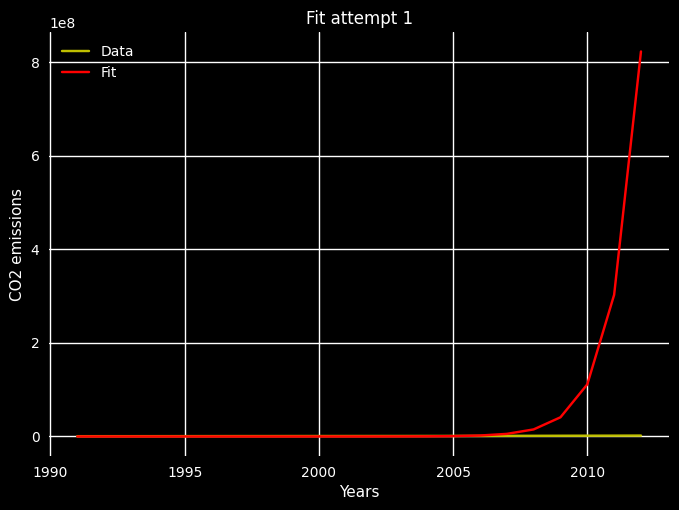

In [119]:
# Plotting the Fitting Attempt Using the values received from the Curve_Fit() and default data

print("Exponential Fit parameter", popt)

# Calling custom plot function defined before to plot the fit model Red & Yellow

fit_plot(pop_stat_orig, "Years", "CO2 emissions", "pop_exp", "Years", "CO2 emissions", "Fit attempt 1", 'y', 'r')


#### 10.4.2 Finding a start approximation & Fitting Attempt 2 (setting CO2 emissions parameter ( popt )values)

In [120]:
# Finding the required start value for the time series data
# After many trials The exponential factor  with 4e8 giving better result
# Growth factor of 0.02 is giving a comprimisable fit

popt = [4e8, 0.02]

pop_stat_orig["pop_exp"] = exp_growth(pop_stat_orig["Years"], *popt)


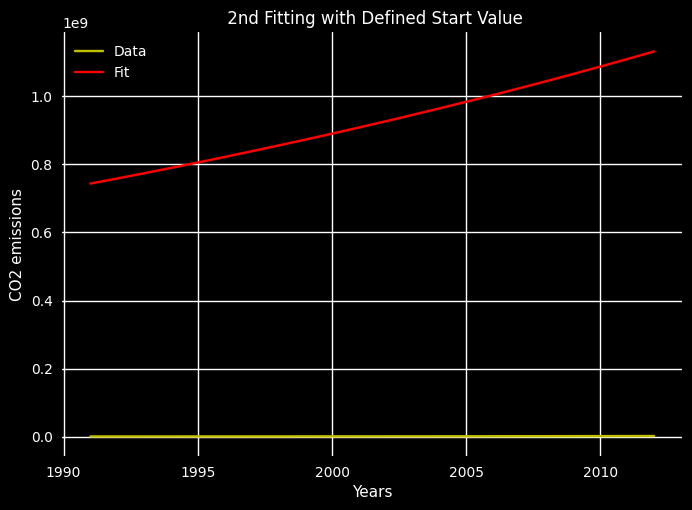

In [121]:
# Calling pre-defined Plotting function for the Fitted Model

fit_plot(pop_stat_orig, "Years", "CO2 emissions", "pop_exp", "Years", "CO2 emissions", 
          " 2nd Fitting with Defined Start Value", 'y', 'r')


#### 10.4.3 Final Fitting using Curve_Fit ( by applying the best Fit parameters obtained above)

In [122]:
# fit exponential growth by applying the best Fit parameters obtained above (we use curve_fit for the fitting of exponential model)
popt, covar = opt.curve_fit(exp_growth, pop_stat_orig["Years"], 
                            pop_stat_orig["CO2 emissions"], p0=[4e8, 0.02])

pop_stat_orig["pop_exp"] = exp_growth(pop_stat_orig["Years"], *popt)

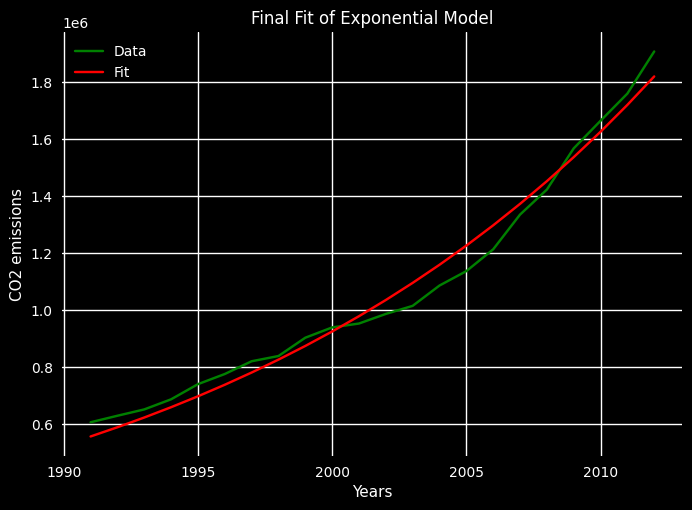

Fit parameter [9.71478720e+04 5.63635161e-02]


In [123]:
# Calling pre-defined Plotting function for the Fitted Model & Displaying Fit Parameters

fit_plot(pop_stat_orig, "Years", "CO2 emissions", "pop_exp", "Years", "CO2 emissions", 
         "Final Fit of Exponential Model", 'g', 'r')

print("Fit parameter", popt) 


#### 10.4.4 Finding Exponential Model Error Ranges

In [124]:
# Finding the upper and lower limits of the error ranges using Error Range Funtion
# extracting the sigma value from the Diagonal of the Covariance-Matrix
sigma = np.sqrt(np.diag(covar))

# Calling the Pre-defined Error Range Funtion to find the error ranges
low, up = err_ranges(pop_stat_orig["Years"], exp_growth, popt, sigma)

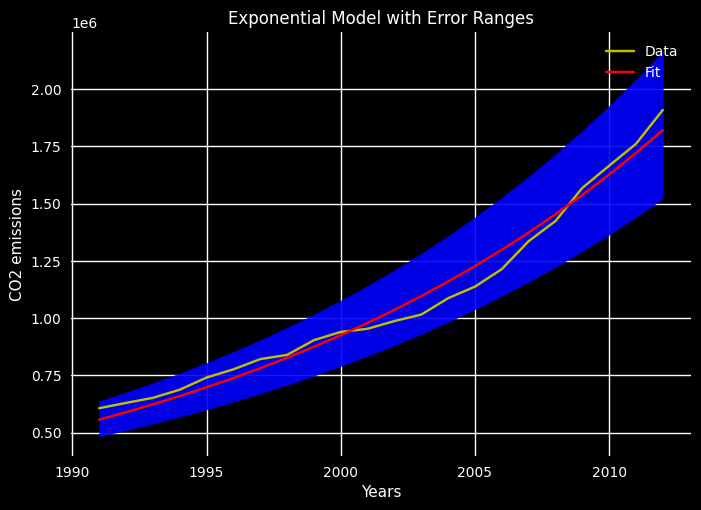

Sigma [8.00935033e+03 1.79376986e-03]


In [125]:
# Calling pre-defined Plotting funtion for the Fitted Model

fit_err_plot(pop_stat_orig, low, up, "Years", "CO2 emissions", "pop_exp", "Years", "CO2 emissions", 
             "Exponential Model with Error Ranges", 'y', 'r', 'b')

print("Sigma", sigma)

#### 10.4.5 Forcasting the Data till the year 2050 using Exponential Model

In [126]:
# Forcasting the data using on upcoming years with upper & lower limits. ie every next 10 year till the year 2050
print("Forcasted CO2 emissions")

low, up = err_ranges(2030, exp_growth, popt, sigma)
print("2030 between ", low, "and", up)

low, up = err_ranges(2040, exp_growth, popt, sigma)
print("2040 between ", low, "and", up)

low, up = err_ranges(2050, exp_growth, popt, sigma)
print("2050 between ", low, "and", up)


Forcasted CO2 emissions
2030 between  4064613.02233069 and 6163910.048301976
2040 between  7014756.512540638 and 11026309.435073648
2050 between  12106148.521370333 and 19724411.74599663


#### 10.4.6 Forcasting the Data till the year 2050 using Exponential Model with Mean & Uncertainity Values

In [127]:
# Printing the Exponenital Model Prediction Uncertainity

print("Forcasted CO2 emissions")
low, up = err_ranges(2030, exp_growth, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2030:", mean, "+/-", pm)

low, up = err_ranges(2040, exp_growth, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2040:", mean, "+/-", pm)

low, up = err_ranges(2050, exp_growth, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2050:", mean, "+/-", pm)

Forcasted CO2 emissions
2030: 5114261.535316333 +/- 1049648.512985643
2040: 9020532.973807143 +/- 2005776.4612665046
2050: 15915280.133683482 +/- 3809131.6123131495


### 10.5 Fitting with Logistics function Model & Forcasting with Uncertainity values

#### 10.5.1 Finding a start approximation & Improved Fitting

In [128]:
# estimated turning year: 1985 to 2000 , The growth what we have seen in 270 Million that is in 2000, 
# CO2 emissions reaches to 1.05Billion
# CO2 emissions in 1985: about 780 million
# best fitting functions happening with growth factor of 0.05 & exponential value of 8e8 with start value 1985

popt = [2e9, 0.05, 1985]

# Calling the pre defined logistics model function with indicators

pop_stat_orig["pop_log"] = logistics(pop_stat_orig["Years"], *popt)


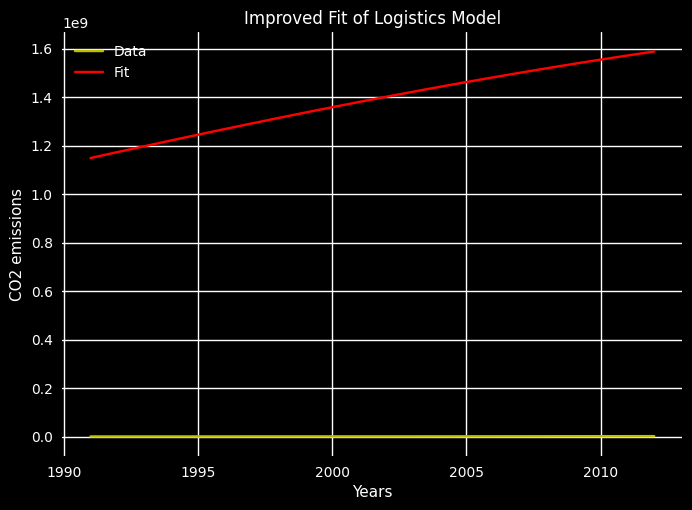

In [129]:
# Calling pre-defined fiting plot
fit_plot (pop_stat_orig, "Years", "CO2 emissions", "pop_log", "Years", 
          "CO2 emissions", "Improved Fit of Logistics Model", 'y', 'r')


In [130]:
#For the china CO2 emissions model 3e9 value works better than 2e9 with growth factor of 0.05
popt_chn = [3e9, 0.05, 1985]

# Callign the pre defined logistics model function with indicators
pop_stat_orig_chn["pop_log_chn"] = logistics(pop_stat_orig_chn["Years"], *popt_chn)


#### 10.5.2 Final Fitting using Curve_Fit (  Logistics Model )

In [132]:
import scipy.optimize as opt

# Adjust initial parameters and increase maxfev
popt, covar = opt.curve_fit(logistics, pop_stat_orig["Years"], pop_stat_orig["CO2 emissions"], 
                            p0=(2e9, 0.05, 1985), maxfev=10000)

# Apply the model with the fitted parameters
pop_stat_orig["pop_log"] = logistics(pop_stat_orig["Years"], *popt)


In [134]:
import scipy.optimize as opt

try:
    # Attempt to fit the logistic model
    popt_chn, covar_chn = opt.curve_fit(logistics, pop_stat_orig_chn["Years"], pop_stat_orig_chn["CO2 emissions"], 
                                        p0=(2e9, 0.05, 1985), maxfev=10000)

    # Apply the model with the fitted parameters
    pop_stat_orig_chn["pop_log_chn"] = logistics(pop_stat_orig_chn["Years"], *popt_chn)
except RuntimeError as e:
    print("An error occurred during curve fitting:", e)


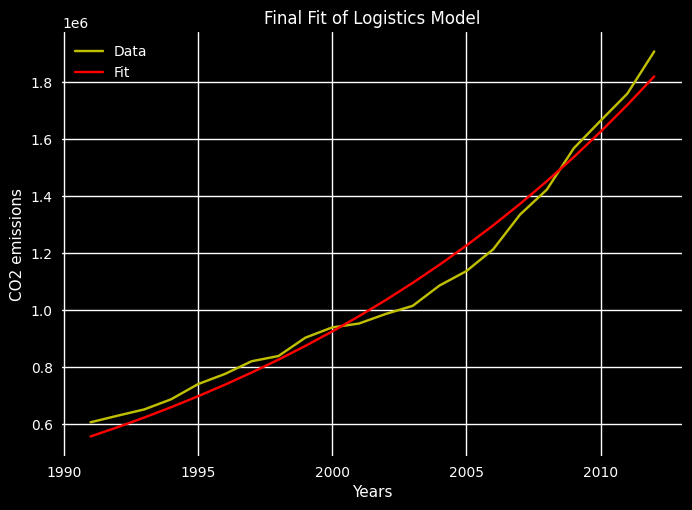

Fit parameter [3.09825178e+11 5.63637250e-02 2.22569022e+03]


In [135]:
fit_plot (pop_stat_orig,"Years", "CO2 emissions", "pop_log", "Years", "CO2 emissions",
          "Final Fit of Logistics Model", 'y', 'r')

print("Fit parameter", popt)


#### 10.5.3 Finding Error Ranges ( Logistics Model )

In [136]:
# Finding the upper and lower limits of the error ranges using Error Range Function for India
# extract the sigmas from the diagonal of the covariance matrix

sigma = np.sqrt(np.diag(covar))
print(sigma)

# Calling the Pre-defined Error Range Function to find the error ranges in the Logistics Model
low, up = err_ranges(pop_stat_orig["Years"], logistics, popt, sigma)


[1.74480668e+16 1.20206413e-02 1.00055114e+06]


In [137]:
# Finding the upper and lower limits of the error ranges using Error Range Function for China
# extract the sigmas from the diagonal of the covariance matrix

sigma_chn = np.sqrt(np.diag(covar_chn))
print(sigma_chn)

# Calling the Pre-defined Error Range Function to find the error ranges into the Logistics Model
low_chn, up_chn = err_ranges(pop_stat_orig_chn["Years"], logistics, popt_chn, sigma_chn)

[2.22080212e+16 1.49640321e-02 3.55728447e+05]


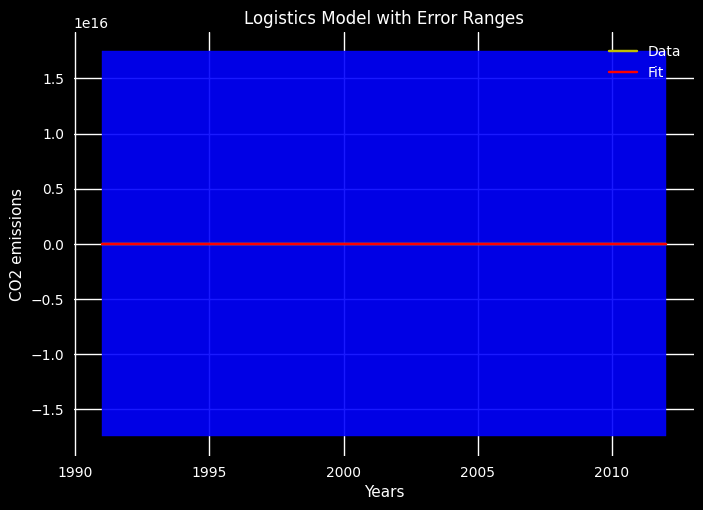

Sigma [1.74480668e+16 1.20206413e-02 1.00055114e+06]


In [138]:
# Calling pre-defined Plotting funtion for the Fitted Model
fit_err_plot(pop_stat_orig, low, up, "Years", "CO2 emissions", "pop_log", "Years",
             "CO2 emissions", "Logistics Model with Error Ranges", 'y', 'r', 'b')

print("Sigma", sigma)

#### 10.5.4 Forcasting the Data till the year 2050 ( Logistics Model )

In [139]:
# Forcasting the data using on upcoming years with upper & lower limits. ie every next 10 year using Logistics Model

print("Forcasted CO2 emissions of India")

low, up = err_ranges(2030, logistics, popt, sigma)
print("2030 between ", low, "and", up)

low, up = err_ranges(2040, logistics, popt, sigma)
print("2040 between ", low, "and", up)

low, up = err_ranges(2050, logistics, popt, sigma)
print("2050 between ", low, "and", up)

Forcasted CO2 emissions of India
2030 between  -1.7447756958410742e+16 and 1.744837660876603e+16
2040 between  -1.7447756958410742e+16 and 1.744837660876603e+16
2050 between  -1.7447756958410742e+16 and 1.744837660876603e+16


In [140]:
# Forcasting the data using on upcoming years with upper & lower limits. ie every next 10 year using Logistics Model
print("Forcasted CO2 emissions of China")
      
low_chn, up_chn = err_ranges(2030, logistics, popt_chn, sigma_chn)
print("2030 between ", low_chn, "and", up_chn)
      
low_chn, up_chn = err_ranges(2040, logistics, popt_chn, sigma_chn)
print("2040 between ", low_chn, "and", up_chn)
      
low_chn, up_chn = err_ranges(2050, logistics, popt_chn, sigma_chn)
print("2050 between ", low_chn, "and", up_chn)

Forcasted CO2 emissions of China
2030 between  -2.2207211297939976e+16 and 2.220883117764547e+16
2040 between  -2.2207211297939976e+16 and 2.220883117764547e+16
2050 between  -2.2207211297939976e+16 and 2.220883117764547e+16


#### 10.5.5 Forcasting the Data till the year 2050 using Logistics Model with Mean & Uncertainity Values

In [141]:
print("Forcasted CO2 emissions of India")
low, up = err_ranges(2030, logistics, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2030:", mean, "+/-", pm)

low, up = err_ranges(2040, logistics, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2040:", mean, "+/-", pm)

low, up = err_ranges(2050, logistics, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2050:", mean, "+/-", pm)

Forcasted CO2 emissions of India
2030: 309825177644.0 +/- 1.7448066783588386e+16
2040: 309825177644.0 +/- 1.7448066783588386e+16
2050: 309825177644.0 +/- 1.7448066783588386e+16


In [142]:
print("Forcasted CO2 emissions of China")
low_chn, up_chn = err_ranges(2030, logistics, popt_chn, sigma_chn)
mean = (up_chn+low_chn)/2.0
pm = (up_chn-low_chn)/2.0
print("2030:", mean, "+/-", pm)

low_chn, up_chn = err_ranges(2040, logistics, popt_chn, sigma_chn)
mean = (up_chn+low_chn)/2.0
pm = (up_chn-low_chn)/2.0
print("2040:", mean, "+/-", pm)

low_chn, up_chn = err_ranges(2050, logistics, popt_chn, sigma_chn)
mean = (up_chn+low_chn)/2.0
pm = (up_chn-low_chn)/2.0
print("2050:", mean, "+/-", pm)

Forcasted CO2 emissions of China
2030: 809939852748.0 +/- 2.2208021237792724e+16
2040: 809939852748.0 +/- 2.2208021237792724e+16
2050: 809939852748.0 +/- 2.2208021237792724e+16


### 10.6 Comparing the Exponential & Logistics Model Result

#### By Analysing the below data, it is evident that the forcasted CO2 emissions by the Logisctics Model far better with lesser uncertainity values than the Exponential Model

#### CO2 emissions Forcast of INDIA

Forcasted CO2 emissions by Exponential Model 
- 2030: 1761142802.478142 +/- 58035361.3904264
- 2040: 2115774968.883082 +/- 75862359.2359544
- 2050: 2541839004.80715 +/- 98514905.2190988

Forcasted CO2 emissions by Logistics Model
- 2030: 1543301431.2071452 +/- 46699966.49086964
- 2040: 1670510746.0098963 +/- 47120391.32927418
- 2050: 1774760904.5372226 +/- 46534203.30912876

#### CO2 emissions Forcast of CHINA

Forcasted CO2 emissions by Logistics Model
- 2030: 1452518112.029258 +/- 11639228.47832489
- 2040: 1481316506.3379145 +/- 10729460.590591788
- 2050: 1500093284.8315427 +/- 9981376.40419054

### 10.7 Plotting the best fitting function and the confidence range

In [143]:
# Defining the envelop for the predicted year including the available year ranges
year_ind = np.arange(1960, 2050)

# Assigning the above created year value with CO2 emissions parameter obtained above to get the forecast shape
forecast_ind = logistics(year_ind, *popt)

In [144]:
# Findign the lower & upper ranges of the envelop using the error range funtion defined before
low_ind, up_ind = err_ranges(year_ind, logistics, popt, sigma)

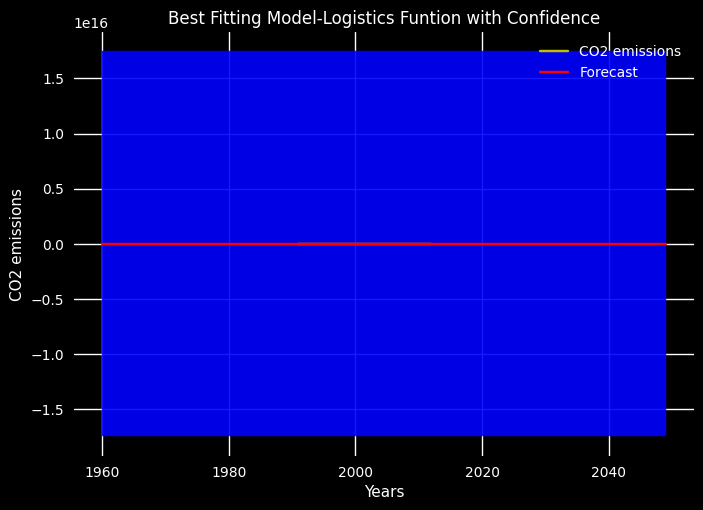

In [145]:
# Calling pre-defined Plotting function for the Fitted Model

best_fit_plot(pop_stat_orig, year_ind, forecast_ind, low_ind, up_ind, "Years",
              "CO2 emissions", "Years", "CO2 emissions", "Best Fitting Model-Logistics Funtion with Confidence",
              'y', 'r','b')

In [146]:
# Defining the envelop for the predicted year including the available year ranges
year_chn = np.arange(1960, 2050)

# Assigning the above created year value with CO2 emissions parameter obtained above to get the forecast shape
forecast_chn = logistics(year_chn, *popt_chn)

In [147]:
# Findign the lower & upper ranges of the envelop using the error range funtion defined before
low_chn, up_chn = err_ranges(year_chn, logistics, popt_chn, sigma_chn)

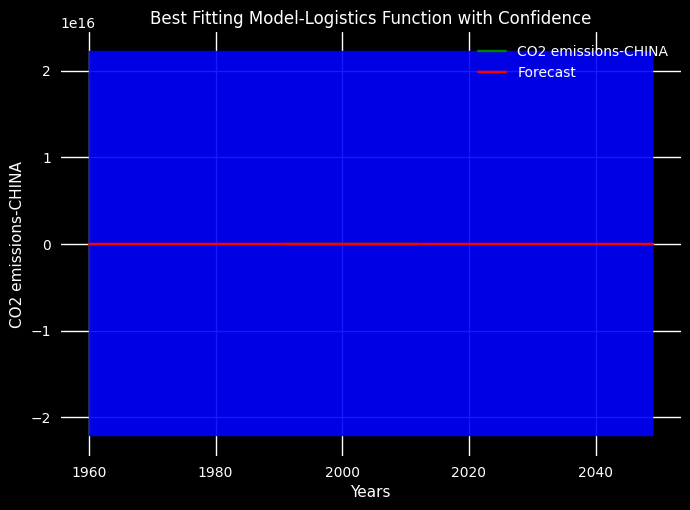

In [148]:
# Calling pre-defined Plotting function for the Fitted Model
best_fit_plot(pop_stat_orig_chn, year_chn, forecast_chn, low_chn, up_chn,
              "Years", "CO2 emissions", "Years", "CO2 emissions-CHINA", "Best Fitting Model-Logistics Function with Confidence",
              'g', 'r', 'b')

# 11. Conclusion

As per the comparitive analysis executed on the two Models ( using Exponential & Logistics funtion) on the section 10, we found out that the Model with Logistics Function producing lessor predictive errors with good confidence value. For this task, we have been using the time series data of INDIA & CHINA. As per our model, the CO2 emissions predictions for the year 2050 has been identified. Below are the details.

- By the start of the year 2050, India will hit the 1.7 billion CO2 emissions mark while the China hits the 1.5 billion CO2 emissions mark



- On the section 9 we did the clustering using K-mean for multiple indicators and produced some interesting analysis. On the seciton 10 we did the Fitting and Prediction using multiple models ( Exponential & Logistics function). Later identified the best fitting model ( Logistics Model) and forcasted the CO2 emissions vlaues of India and China with a good confidence lesser error ranges



- The final poster is created with the data that are analyzed above.